# PyStan - transit model

PyStan is the Python implementation of the Stan statistical modelling language.  Stan provides a framework for easily setting up probabilistic models and performing Bayesian inference with MCMC sampling.  There is of course a lot of detail behind how the sampler works, but this is going to be a short example of an application of Stan to a simple parameter estimation problem.

I'm going to apply Stan to fit a model of a transit and estimate the parameters involved.  Then I'll check the fit by making a posterior predictive check, another really convenient feature of Stan.

The only uncommon imports here are *pystan* itself and *corner*, a tool for creating triangle plots. Just pip install these.

In [1]:
import matplotlib, pickle
import numpy as np
import matplotlib.pyplot as plt
from pystan import stan
import corner

matplotlib.style.use('ggplot')
%matplotlib inline

### Creat mock data

First thing to do is create some fake data. Our transit will be defined by five parameters: the mean luminosity before and during, A and B, the central time and width of transit, t_c and w, and an extra noise parameter sigma which I assume to be the same at all times.

In [2]:
class transit():

    def __init__(self,num_samples,A,B,t_c,w,sigma):
        self.num_samples = num_samples
        self.A = A
        self.B = B
        self.t_c = t_c
        self.w = w
        self.sigma = sigma

    def generate_data(self):
        self.t_sample = np.arange(self.num_samples)
        self.data = np.zeros(self.num_samples)
        
        for i,t in enumerate(self.t_sample):
            if (t<self.t_c-self.w/2.) or (t>self.t_c+self.w/2.):
                self.data[i] = np.random.normal(self.A,self.sigma,1)
                
            else: 
                self.data[i] = np.random.normal(self.A-self.B,self.sigma,1)

        return self.t_sample, self.data

    def plot_data(self,file_name):
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111)
        ax.set_title('Mock transit data')
        ax.set_ylabel('Luminosity')
        ax.set_xlabel('Time')
        ax.scatter(self.t_sample, self.data)
        fig.savefig(file_name,bbox_inches='tight')
        return fig

In [3]:
num_samples = 200
A = 30
B = 20
t_c = 100
w = 70
t1=t_c-w/2
t2=t_c+w/2
sigma = 0.5 

trans = transit(num_samples,A,B,t_c,w,sigma)
data = trans.generate_data()

Plotting this data shows the crude transit shape:

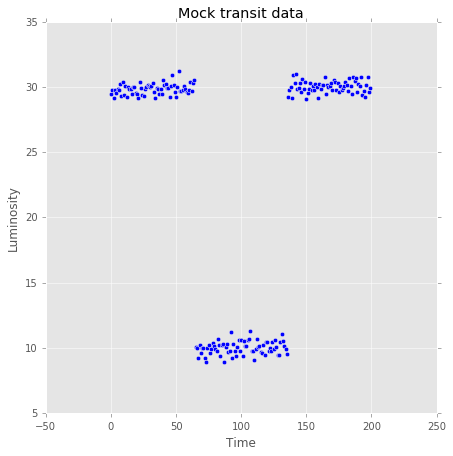

In [4]:
fig = trans.plot_data('plots/mock_data_plot.png')

### Write the Stan code

Now lets write the Stan code itself.  
Whichever implementation of Stan you are using, the code remains of the same form. It is split into blocks: *data*, *parameters*, *transformed parameters*, *model*, and *generated quantities*. It is possible to define other blocks with functions, or other features, however I have not used that here.  

We also have to tell Stan exactly what our data is in dictionary format.  

In [29]:
stan_code = """

data  {
        int<lower=0> N; // number of data points
        real<lower=0> t[N]; // time at each data point
        real<lower=0> L[N]; // luminosity at each data point
}

parameters  {
    real<lower=25,upper=35> A; //declare all the parameters used in them model
    real<lower=5,upper=15> B;
    real<lower=50,upper=90> t1;
    real<lower=110,upper=150> t2;
    real<lower=0> sigma;
}

transformed parameters {
                            //A place for the transformed convenient
                            //parameters you may want. Stan handles 
                            //the Jacobian etc for you.
}

model  {

    A ~ uniform(25,35);   //Make up some priors.
    B ~ uniform(5,15);
    t1 ~ uniform(50,90);
    t2 ~ uniform(110,150);
    sigma ~ normal(0.5,0.1);

    for (m in 1:N) {                  //This is the actual likelihood model.
           if (t[m]<t1 || t[m]>t2)
              L[m] ~ normal(A,sigma);
           else
              L[m] ~ normal(B,sigma);}

}

generated quantities {        //Here define some function to compute on each iteration. Note that this is not
                              //found by sampling, but by a pseudo random number generator, hence the rng suffix.
          real L_pred[N];

          for (m in 1:N)
              if (t[m]<t1 || t[m]>t2)
                 L_pred[m] <- normal_rng(A,sigma);
              else
                 L_pred[m] <- normal_rng(B,sigma);
}

"""

stan_data = {

    'N' : data[0].size,
    't' : data[0],
    'L' : data[1]

}


### Run the code with our data

The keywords I have specified in the call to stan, *iter* and *chains* are the total number of iterations and MCMC chains that will be used.  These can be tweaked to optimize for speed or full exploration of the parameter space.  For example, when I ran this code with only 1000 iterations the posterior predictives looked awful - I wasn't fully exploring the parameter space.

In [17]:
fit = stan(model_code=stan_code, data=stan_data, iter=5000, chains=4)

When the fit has finished running the samples have to be extracted:

In [18]:
samples = fit.extract(permuted=True)

### Make a plot of the posterior predictive

Here we are only plotting one sampling from the posterior predictive.  Whilst running the code we actually sampled from it at every iteration. We can use all these samples to create a confidence region, like a shaded area on out plot corresponding to the data realizations.  However we do not do that here.

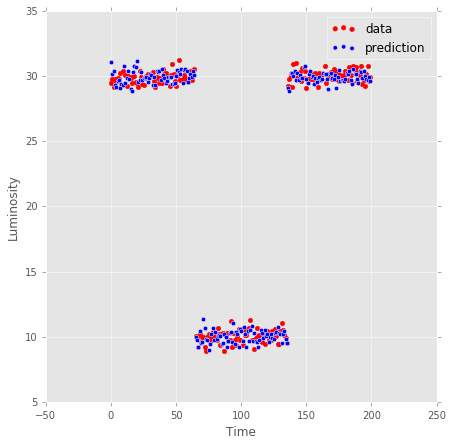

In [19]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_title('')
ax.set_ylabel('Luminosity')
ax.set_xlabel('Time')
ax.scatter(data[0], data[1],color='r',label='data')
ax.scatter(np.arange(200), samples['L_pred'][100],label='prediction')
ax.legend()
fig.savefig('plots/data_pred.png')

Finally we make a corner plot of the parameter posterior.  We see that we get a reasonable bound on the parameters A, B and sigma.  However the two time parameters are still relatively ill-defined.  I am not sure about the reason for this.  There is no effect on the posterior predictives, where we see the correct sharp cut off. 

In [20]:
corner_samples =  np.array([samples['A'],samples['B'],samples['sigma'],samples['t1'],samples['t2']]).T

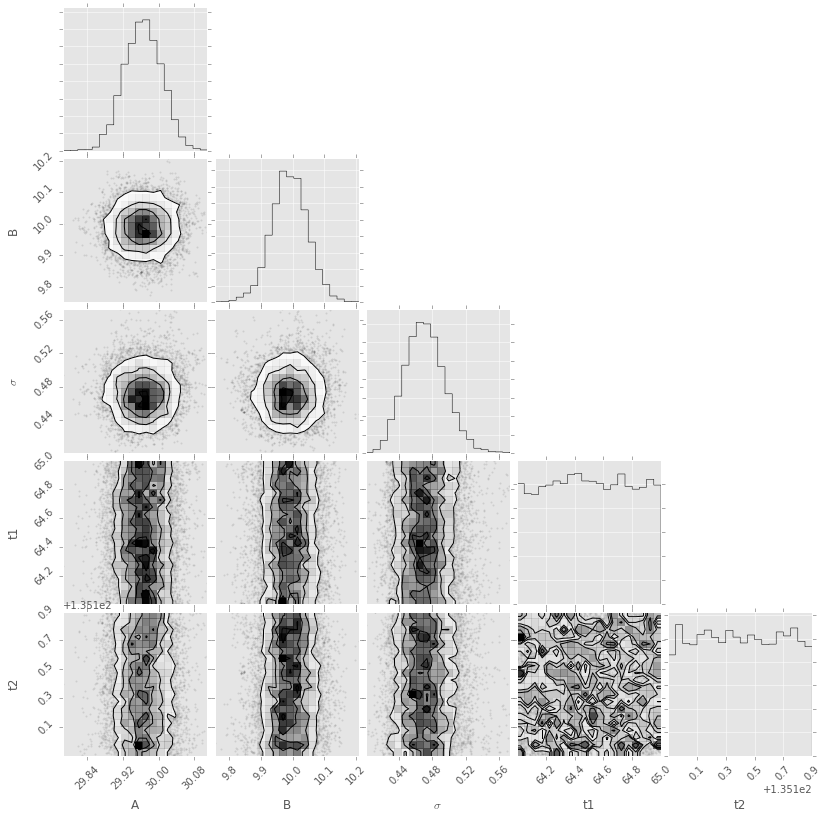

In [21]:
fig = corner.corner(corner_samples, 
                    labels=['A','B',r'$\sigma$','t1','t2'])
fig.savefig('plots/corner.png',bbox_inches='tight')